In [42]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from collections import Counter
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import os
import sys

Fluxo de funcionamento:
- Lê tabela que associa o nome da imagem com a legenda
- Separa os dados de treino, validação e teste
- Constrói vocabulário apenas com as legendas de treinamento
- Instancia um dataset e dataloader para treino, validação e teste 
- Constrói matriz de embeddings pré-treinados procurando os tokens no Glove

In [43]:
# Adiciona o diretório pai (raiz do projeto) ao path do sistema
sys.path.append(os.path.abspath(".."))

# ativar autoreload -> capturar mudanças do código fonte
%load_ext autoreload
%autoreload 2

from src.dataset import Vocabulary, FlickrDataset, build_glove_matrix

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Vocabulary e Dataloader

In [44]:
df = pd.read_csv("../data/flickr8k_cleaned_data.csv")

# Primeiro split: Treino vs Resto (Validação + Teste)
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)

# Segundo split: Divide o resto entre Validação e Teste
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

In [45]:
train_captions = train_df['caption_clean'].tolist()

min_freq=1

vocab = Vocabulary(min_freq)
vocab.build_vocabulary(train_captions)

print(f"Vocabulário criado com {len(vocab)} tokens")

Vocabulário criado com 7313 tokens


In [46]:
caption_example = train_captions[0]
caption_tokenized = vocab.tokenize(caption_example)

print(f"Legenda original: {caption_example}")
print(f"Após tokenização: {caption_tokenized}")

Legenda original: a boy holding a lightsaber jumps in the middle of the street
Após tokenização: [4, 5, 6, 4, 7, 8, 9, 10, 11, 12, 10, 13]


In [47]:
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),         
    # Média e desvio padrão para cada canal de cor do imagenet
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) 
])

batch_size = 4
max_tokens = 25

train_dataset = FlickrDataset("../data/Images", train_df, vocab, transform=transform, max_tokens=max_tokens)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = FlickrDataset("../data/Images", val_df, vocab, transform=transform, max_tokens=max_tokens)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = FlickrDataset("../data/Images", test_df, vocab, transform=transform, max_tokens=max_tokens)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [48]:
dataiter = iter(train_loader)
images, captions = next(dataiter)

# Verificar as dimensões
print(f"Shape das imagens: {images.shape}")   # Esperado: [4, 3, H, W]
print(f"Shape das legendas: {captions.shape}") # Esperado: [4, max_tokens]

print(f"\nPrimeira legenda do batch:\n{captions[0]}")

Shape das imagens: torch.Size([4, 3, 224, 224])
Shape das legendas: torch.Size([4, 25])

Primeira legenda do batch:
tensor([ 1,  4,  5,  6,  4,  7,  8,  9, 10, 11, 12, 10, 13,  2,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0])


In [49]:
def show_img_and_cap(images, captions, vocab):
    # Valores de desnormalização baseados no ImageNet
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

    for i, (img, cap) in enumerate(zip(images, captions)):\
        # Desnormaliza para voltar aos tons originais
        img_vis = img * std + mean 

        # Permuta de (C, H, W) para (H, W, C) para o Matplotlib
        img_plot = img_vis.permute(1, 2, 0).numpy()
        img_plot = np.clip(img_plot, 0, 1)

        tokenized_ids = cap.tolist()

        # Legenda Destokenizada (Texto legível)
        # Filtramos tokens especiais para a leitura ficar mais fluida
        ignore_tokens = [vocab.stoi["<PAD>"], vocab.stoi["<SOS>"], vocab.stoi["<EOS>"]]
        destokenized_words = [vocab.itos[token.item()] for token in cap if token.item() not in ignore_tokens]
        destokenized_cap = " ".join(destokenized_words)

        # Exibição dos resultados
        print(f"--- Exemplo {i+1} ---")
        print(f"Tokenizada (IDs): {tokenized_ids}")
        print(f"Destokenizada: {destokenized_cap}")
        
        plt.figure(figsize=(5, 4))
        plt.imshow(img_plot)
        plt.title(f"Amostra {i+1}", fontsize=10)
        plt.axis('off')
        plt.show()

--- Exemplo 1 ---
Tokenizada (IDs): [1, 4, 5, 6, 4, 7, 8, 9, 10, 11, 12, 10, 13, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Destokenizada: a boy holding a lightsaber jumps in the middle of the street


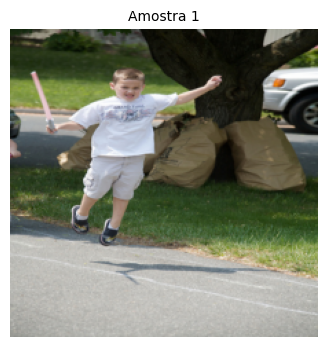

--- Exemplo 2 ---
Tokenizada (IDs): [1, 4, 14, 15, 16, 17, 18, 19, 4, 20, 21, 22, 23, 24, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Destokenizada: a young asian girl is sliding down a pole on outdoor playground equipment


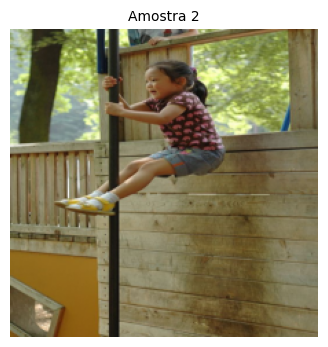

--- Exemplo 3 ---
Tokenizada (IDs): [1, 4, 16, 25, 4, 26, 21, 4, 27, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Destokenizada: a girl riding a scooter on a sidewalk


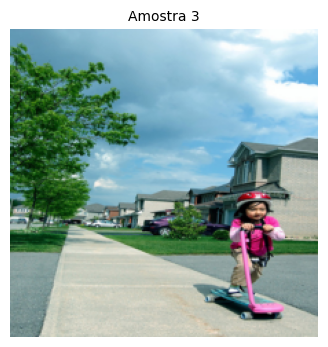

--- Exemplo 4 ---
Tokenizada (IDs): [1, 4, 16, 28, 4, 29, 30, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Destokenizada: a girl climbs a rock wall


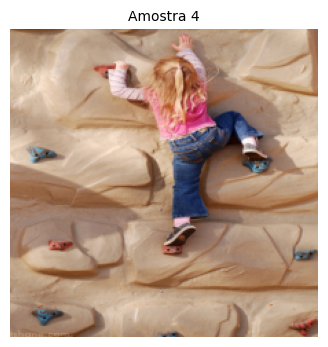

In [50]:
show_img_and_cap(images, captions, vocab)

# Matriz de Embeddings

In [51]:
glove_path = "../Embeddings/glove.6B.100d.txt"

glove_matrix, words_not_found = build_glove_matrix(vocab, glove_path, embedding_dim=100)

Sucesso: 6832/7313 palavras encontradas no Glove


In [52]:
glove_matrix.shape # esperado: len(vocab), 100

torch.Size([7313, 100])

In [53]:
words_not_found[:20]

['<PAD>',
 '<SOS>',
 '<EOS>',
 '<UNK>',
 'longsleeve',
 'wakeboarder',
 'chrismas',
 'dalmation',
 'wearubg',
 'telephot',
 'feamle',
 'bicycler',
 'jumpropes',
 'convienance',
 'retreiver',
 'largley',
 'goucho',
 'hods',
 'racedog',
 'youngle']

In [54]:
glove_matrix[0] # esperado: vetor de dimensão 100 preenchido apenas com zeros

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])

In [55]:
glove_matrix[100] # indíce aleatório

tensor([-8.5973e-01,  6.3461e-01, -1.2718e-01,  5.9427e-01, -8.4997e-01,
        -1.0821e-01, -1.7513e-01, -1.3402e-01, -3.0666e-01,  8.8678e-02,
         5.3000e-01, -6.1496e-01,  6.3637e-01,  3.1729e-01,  4.6516e-01,
        -9.6767e-02, -7.2394e-02,  4.1993e-01, -2.6422e-01,  5.9249e-02,
         3.4407e-01,  1.8502e-01,  8.1215e-01, -6.3094e-01,  3.1310e-01,
         3.8436e-01, -2.5037e-01,  1.4791e-01, -1.7613e-01,  4.1421e-01,
        -2.6192e-01, -9.3190e-02, -9.2725e-02,  4.5874e-01,  3.9650e-01,
        -2.9523e-04, -4.9283e-01,  2.5662e-01,  2.9661e-01,  1.5222e-01,
        -2.4027e-01, -9.1703e-01,  1.6796e-01, -4.3937e-01,  4.5800e-01,
         3.0575e-01,  9.6427e-02,  2.1598e-01, -5.0224e-02, -8.2300e-01,
         2.7513e-01, -2.2445e-01,  1.9959e-02,  1.8232e+00, -1.9746e-01,
        -2.0729e+00, -3.6011e-02, -4.0233e-01,  1.9194e+00,  3.5738e-01,
         1.5693e-01,  8.7732e-01,  1.4364e-01,  4.5433e-01,  4.5805e-01,
        -3.4624e-01,  5.9678e-02, -2.8850e-01, -4.8